In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
import warnings

# 设置中文字体显示
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
sns.set(font="Kaiti", style="ticks", font_scale=1.4)
warnings.filterwarnings('ignore')

In [13]:
class DataMiningProject:
    def __init__(self, data_path):
        """
        初始化数据挖掘项目类
        
        Parameters:
        data_path (str): 数据文件路径
        """
        self.data_path = data_path
        self.data = None
        self.X = None
        self.Y = None
        self.X_train = None
        self.X_test = None
        self.Y_train = None
        self.Y_test = None
        self.models = {}
        self.results = {}
        
    def load_data(self):
        """
        加载数据并进行初步处理
        """
        try:
            # 读取数据
            self.data = pd.read_excel(self.data_path)
            print(f"数据加载成功，形状: {self.data.shape}")
            
            # 删除指定列
            columns_to_drop = ["chrill", "supf"]
            for col in columns_to_drop:
                if col in self.data.columns:
                    self.data = self.data.drop(columns=[col])
                    print(f"已删除列: {col}")
                else:
                    print(f"警告: 列 '{col}' 不存在")
            
            # 分离特征和目标变量
            self.Y = self.data["retdelw"]
            self.X = self.data.iloc[:, 1:]
            print(f"特征数据形状: {self.X.shape}")
            print(f"目标变量形状: {self.Y.shape}")
            
            return True
            
        except FileNotFoundError:
            print(f"错误: 找不到文件 {self.data_path}")
            return False
        except Exception as e:
            print(f"加载数据时发生错误: {str(e)}")
            return False

    
    def check_data_quality(self):
        """
        检查数据质量
        """
        if self.data is None:
            print("错误: 请先加载数据")
            return False
        
        print("=" * 50)
        print("数据质量检查")
        print("=" * 50)
        
        # 检查缺失值
        missing_values = self.data.isnull().sum()
        total_missing = missing_values.sum()
        
        print(f"总缺失值数量: {total_missing}")
        if total_missing > 0:
            print("各列缺失值情况:")
            for col, missing in missing_values[missing_values > 0].items():
                print(f"  {col}: {missing} 个缺失值")
        else:
            print("数据中没有缺失值")
        
        # 检查数据类型
        print("\n数据类型:")
        print(self.data.dtypes)
        
        # 基本统计信息
        print("\n数据基本统计信息:")
        print(self.data.describe())
        
        return total_missing == 0

        
    def exploratory_analysis(self, nums):
        """
        探索性数据分析
        """
        if self.data is None:
            print("错误: 请先加载数据")
            return False
        
        
        # 创建数据副本用于可视化
        data1 = self.data.copy()
        data1['retdelw_label'] = data1['retdelw'].apply(lambda x: '无' if x == 0 else '有')

        if nums == 1:
            # 1. 目标变量分布 - 柱状图
            plt.figure(figsize=(10, 5))
            
            plt.subplot(1, 2, 1)
            sns.countplot(x='retdelw_label', data=data1, order=['无', '有'], 
                         width=0.5, palette='coolwarm')
            plt.xlabel("延迟退休意愿")
            plt.ylabel("样本个数")
            plt.title("延迟退休意愿分布 - 柱状图")
            plt.savefig("fig/延迟退休意愿分布_柱状图.png", dpi=300, bbox_inches='tight')
            plt.show()

        if nums == 2:
            # 2. 目标变量分布 - 饼图
            plt.subplot(1, 2, 2)
            label_counts = data1['retdelw_label'].value_counts()
            plt.pie(label_counts, labels=label_counts.index, autopct='%2.2f%%', 
                    startangle=120, colors=["#f0bea7", "#b5caf9"],
                    textprops={'fontsize': 12}, labeldistance=1.2)
            plt.title("延迟退休意愿分布 - 饼图")
            
            plt.tight_layout()
            plt.savefig("fig/延迟退休意愿分布_饼图.png", dpi=300, bbox_inches='tight')
            plt.show()

        if nums == 3:
            # 3. 特征相关性分析
            plt.figure(figsize=(12,12)) 
    
            plt.subplot(3, 3, 1)
            sns.boxplot(x='retdelw', y='age', data=data1, palette = 'coolwarm')
            plt.ylabel('年龄')
            plt.xlabel("有无退休意愿")
            
            plt.subplot(3, 3, 2)
            sns.boxplot(x='retdelw', y='edu', data=data1, palette = 'coolwarm')
            plt.ylabel('教育程度')
            plt.xlabel("有无退休意愿")
            
            plt.subplot(3, 3, 3)
            sns.boxplot(x='retdelw', y='lwage', data=data1, palette = 'coolwarm')
            plt.ylabel('收入水平')
            plt.xlabel("有无退休意愿")
    
            plt.subplot(3, 3, 4)
            sns.countplot(x='sex', hue='retdelw', data=data1, palette = 'coolwarm')
            plt.legend().set_visible(False)
            plt.ylabel('样本个数')
            plt.xlabel("性别")
            #plt.title('Sex vs. retdelw')
             
            plt.subplot(3, 3, 5)
            sns.countplot(x='mar', hue='retdelw', data=data1, palette = 'coolwarm')
            plt.legend().set_visible(False) 
            plt.ylabel('样本个数')
            plt.xlabel("配偶")
            
            plt.subplot(3, 3, 6)
            sns.countplot(x='hukou', hue='retdelw', data=data1, palette = 'coolwarm')
            plt.legend().set_visible(False) 
            plt.ylabel('样本个数')
            plt.xlabel("户口类型")
            
            plt.subplot(3, 3, 7)
            sns.countplot(x='heal', hue='retdelw', data=data1, palette = 'coolwarm')
            plt.legend().set_visible(False) 
            plt.ylabel('样本个数')
            plt.xlabel("健康水平")
        
            plt.subplot(3, 3, 8)
            sns.countplot(x='supc', hue='retdelw', data=data1, palette = 'coolwarm')
            plt.legend().set_visible(False) 
            plt.ylabel('样本个数')
            plt.xlabel("子辈对父辈的经济支持")
            
            plt.subplot(3, 3, 9)
            sns.countplot(x='schkid', hue='retdelw', data=data1, palette = 'coolwarm')
            plt.legend().set_visible(False)
            plt.ylabel('样本个数')
            plt.xlabel("在学孩子个数")
            
            plt.tight_layout()
            plt.savefig("fig/相关性分析.png")
            plt.show()
        
        return True

    
    def logistic_regression_analysis(self):
        """
        逻辑回归分析 - 查看变量显著性
        """
        if self.X is None or self.Y is None:
            print("错误: 请先加载数据")
            return False
        
        print("=" * 50)
        print("逻辑回归显著性分析")
        print("=" * 50)
        
        try:
            # 添加常数项
            X_with_const = sm.add_constant(self.X)
            
            # 创建并拟合逻辑回归模型
            logit_model = sm.Logit(self.Y, X_with_const)
            result = logit_model.fit()
            
            print(result.summary())
            
            # 保存结果
            self.results['logistic_summary'] = result
            
            return True
            
        except Exception as e:
            print(f"逻辑回归分析时发生错误: {str(e)}")
            return False
    
    def prepare_model_data(self, test_size=0.3, random_state=42):
        """
        准备模型训练和测试数据
        """
        if self.X is None or self.Y is None:
            print("错误: 请先加载数据")
            return False
        
        try:
            self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(
                self.X, self.Y, test_size=test_size, random_state=random_state, stratify=self.Y
            )
            
            print(f"训练集形状: {self.X_train.shape}")
            print(f"测试集形状: {self.X_test.shape}")
            print(f"训练集目标分布:\n{self.Y_train.value_counts()}")
            print(f"测试集目标分布:\n{self.Y_test.value_counts()}")
            
            return True
            
        except Exception as e:
            print(f"准备数据时发生错误: {str(e)}")
            return False
    


    def train_logistic_regression(self):
        """
        训练逻辑回归模型
        """
        if self.X_train is None:
            print("错误: 请先准备训练数据")
            return False
        
        try:
            print("=" * 50)
            print("训练逻辑回归模型")
            print("=" * 50)
            
            # 创建并训练模型
            lr_model = LogisticRegression(random_state=42, max_iter=1000)
            lr_model.fit(self.X_train, self.Y_train)
            
            # 训练集预测和评估
            Y_train_pred = lr_model.predict(self.X_train)
            Y_train_pred_proba = lr_model.predict_proba(self.X_train)[:, 1]
            train_accuracy = accuracy_score(self.Y_train, Y_train_pred)
            train_cm = confusion_matrix(self.Y_train, Y_train_pred)
            train_report = classification_report(self.Y_train, Y_train_pred)
            
            # 测试集预测和评估
            Y_test_pred = lr_model.predict(self.X_test)
            Y_test_pred_proba = lr_model.predict_proba(self.X_test)[:, 1]
            test_accuracy = accuracy_score(self.Y_test, Y_test_pred)
            test_cm = confusion_matrix(self.Y_test, Y_test_pred)
            test_report = classification_report(self.Y_test, Y_test_pred)
            
            print("训练集性能:")
            print(f"逻辑回归训练集准确率: {train_accuracy:.4f}")
            print("训练集混淆矩阵:")
            print(train_cm)
            print("训练集分类报告:")
            print(train_report)
            
            print("\n" + "-" * 30)
            print("测试集性能:")
            print(f"逻辑回归测试集准确率: {test_accuracy:.4f}")
            print("测试集混淆矩阵:")
            print(test_cm)
            print("测试集分类报告:")
            print(test_report)
        
            # 保存模型和结果
            self.models['logistic_regression'] = lr_model
            self.results['logistic_regression'] = {
                'train_accuracy': train_accuracy,
                'train_confusion_matrix': train_cm,
                'train_classification_report': train_report,
                'train_predictions': Y_train_pred,
                'train_probabilities': Y_train_pred_proba,
                'test_accuracy': test_accuracy,
                'test_confusion_matrix': test_cm,
                'test_classification_report': test_report,
                'test_predictions': Y_test_pred,
                'test_probabilities': Y_test_pred_proba
            }
            return True
        
        except Exception as e:
            print(f"训练逻辑回归模型时发生错误: {str(e)}")
            return False
           


    def train_decision_tree(self, param_grid=None):
        """
        训练决策树模型
        """
        if self.X_train is None:
            print("错误: 请先准备训练数据")
            return False
        
        try:
            print("=" * 50)
            print("训练决策树模型")
            print("=" * 50)
            
            # 默认参数网格
            if param_grid is None:
                param_grid = {
                    'max_depth': [3, 5, 7, 10, None],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
        
            # 创建并训练模型
            dt_model = DecisionTreeClassifier(random_state=42)
            grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            grid_search.fit(self.X_train, self.Y_train)
            
            # 最佳模型
            best_dt_model = grid_search.best_estimator_
            
            # 训练集预测和评估
            Y_train_pred = best_dt_model.predict(self.X_train)
            Y_train_pred_proba = best_dt_model.predict_proba(self.X_train)[:, 1]
            train_accuracy = accuracy_score(self.Y_train, Y_train_pred)
            train_cm = confusion_matrix(self.Y_train, Y_train_pred)
            train_report = classification_report(self.Y_train, Y_train_pred)
            
            # 测试集预测和评估
            Y_test_pred = best_dt_model.predict(self.X_test)
            Y_test_pred_proba = best_dt_model.predict_proba(self.X_test)[:, 1]
            test_accuracy = accuracy_score(self.Y_test, Y_test_pred)
            test_cm = confusion_matrix(self.Y_test, Y_test_pred)
            test_report = classification_report(self.Y_test, Y_test_pred)
        
            print(f"决策树最佳参数: {grid_search.best_params_}")
            
            print("训练集性能:")
            print(f"决策树训练集准确率: {train_accuracy:.4f}")
            print("训练集混淆矩阵:")
            print(train_cm)
            
            print("\n" + "-" * 30)
            print("测试集性能:")
            print(f"决策树测试集准确率: {test_accuracy:.4f}")
            print("测试集混淆矩阵:")
            print(test_cm)
            print("测试集分类报告:")
            print(test_report)
            
            # 保存模型和结果
            self.models['decision_tree'] = best_dt_model
            self.results['decision_tree'] = {
                'train_accuracy': train_accuracy,
                'train_confusion_matrix': train_cm,
                'train_classification_report': train_report,
                'train_predictions': Y_train_pred,
                'train_probabilities': Y_train_pred_proba,
                'test_accuracy': test_accuracy,
                'test_confusion_matrix': test_cm,
                'test_classification_report': test_report,
                'best_params': grid_search.best_params_,
                'test_predictions': Y_test_pred,
                'test_probabilities': Y_test_pred_proba
            }
            
            return True
            
        except Exception as e:
            print(f"训练决策树模型时发生错误: {str(e)}")
            return False



    def train_random_forest(self, param_grid=None):
        """
        训练随机森林模型
        """
        if self.X_train is None:
            print("错误: 请先准备训练数据")
            return False
        
        try:
            print("=" * 50)
            print("训练随机森林模型")
            print("=" * 50)
            
            # 默认参数网格
            if param_grid is None:
                param_grid = {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [3, 5, 7, 10, None],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
        
            # 创建并训练模型
            rf_model = RandomForestClassifier(random_state=42)
            grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            grid_search.fit(self.X_train, self.Y_train)
            
            # 最佳模型
            best_rf_model = grid_search.best_estimator_
            
            # 训练集预测和评估
            Y_train_pred = best_rf_model.predict(self.X_train)
            Y_train_pred_proba = best_rf_model.predict_proba(self.X_train)[:, 1]
            train_accuracy = accuracy_score(self.Y_train, Y_train_pred)
            train_cm = confusion_matrix(self.Y_train, Y_train_pred)
            train_report = classification_report(self.Y_train, Y_train_pred)
            
            # 测试集预测和评估
            Y_test_pred = best_rf_model.predict(self.X_test)
            Y_test_pred_proba = best_rf_model.predict_proba(self.X_test)[:, 1]
            test_accuracy = accuracy_score(self.Y_test, Y_test_pred)
            test_cm = confusion_matrix(self.Y_test, Y_test_pred)
            test_report = classification_report(self.Y_test, Y_test_pred)
            
            print(f"随机森林最佳参数: {grid_search.best_params_}")
        
            print("训练集性能:")
            print(f"随机森林训练集准确率: {train_accuracy:.4f}")
            print("训练集混淆矩阵:")
            print(train_cm)
            
            print("\n" + "-" * 30)
            print("测试集性能:")
            print(f"随机森林测试集准确率: {test_accuracy:.4f}")
            print("测试集混淆矩阵:")
            print(test_cm)
            print("测试集分类报告:")
            print(test_report)
            
            # 特征重要性
            feature_importance = pd.DataFrame({
                'feature': self.X.columns,
                'importance': best_rf_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("特征重要性:")
            print(feature_importance)
            
            # 可视化特征重要性
            plt.figure(figsize=(8, 6))
            sns.barplot(data=feature_importance, x='importance', y='feature')
            plt.title('随机森林特征重要性')
            plt.tight_layout()
            plt.savefig("fig/随机森林特征重要性.png", dpi=300, bbox_inches='tight')
            plt.show()
            
            # 保存模型和结果
            self.models['random_forest'] = best_rf_model
            self.results['random_forest'] = {
                'train_accuracy': train_accuracy,
                'train_confusion_matrix': train_cm,
                'train_classification_report': train_report,
                'train_predictions': Y_train_pred,
                'train_probabilities': Y_train_pred_proba,
                'test_accuracy': test_accuracy,
                'test_confusion_matrix': test_cm,
                'test_classification_report': test_report,
                'best_params': grid_search.best_params_,
                'feature_importance': feature_importance,
                'test_predictions': Y_test_pred,
                'test_probabilities': Y_test_pred_proba
            }
            
            return True
        
        except Exception as e:
            print(f"训练随机森林模型时发生错误: {str(e)}")
            return False 

      

### **1.导入数据，并删除不需要的变量**

In [14]:
analyzer = DataMiningProject("data/data_project/final_data.xlsx")
analyzer.load_data()

数据加载成功，形状: (2096, 12)
已删除列: chrill
已删除列: supf
特征数据形状: (2096, 9)
目标变量形状: (2096,)


True

### **2.检查数据是否存在缺失值及统计信息**

In [15]:
analyzer.check_data_quality()

数据质量检查
总缺失值数量: 0
数据中没有缺失值

数据类型:
retdelw      int64
sex          int64
age          int64
edu          int64
mar          int64
lwage      float64
hukou        int64
heal         int64
supc         int64
schkid       int64
dtype: object

数据基本统计信息:
           retdelw          sex          age          edu          mar  \
count  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000   
mean      0.577290     0.646947    52.527195     4.610210     0.947042   
std       0.494108     0.478033     3.880091     1.999349     0.224003   
min       0.000000     0.000000    45.000000     1.000000     0.000000   
25%       0.000000     0.000000    49.000000     4.000000     1.000000   
50%       1.000000     1.000000    53.000000     5.000000     1.000000   
75%       1.000000     1.000000    55.000000     5.000000     1.000000   
max       1.000000     1.000000    60.000000    10.000000     1.000000   

             lwage        hukou         heal         supc       schkid  
count  2096.

True

### **3.探索性分析**

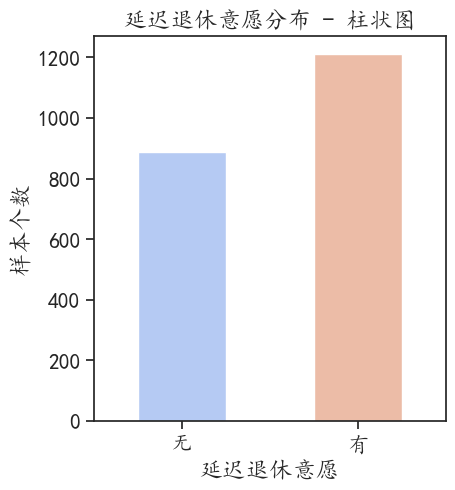

True

In [16]:
analyzer.exploratory_analysis(nums=1)

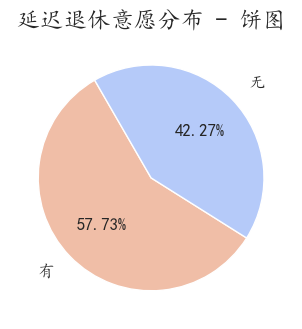

True

In [17]:
analyzer.exploratory_analysis(nums=2)

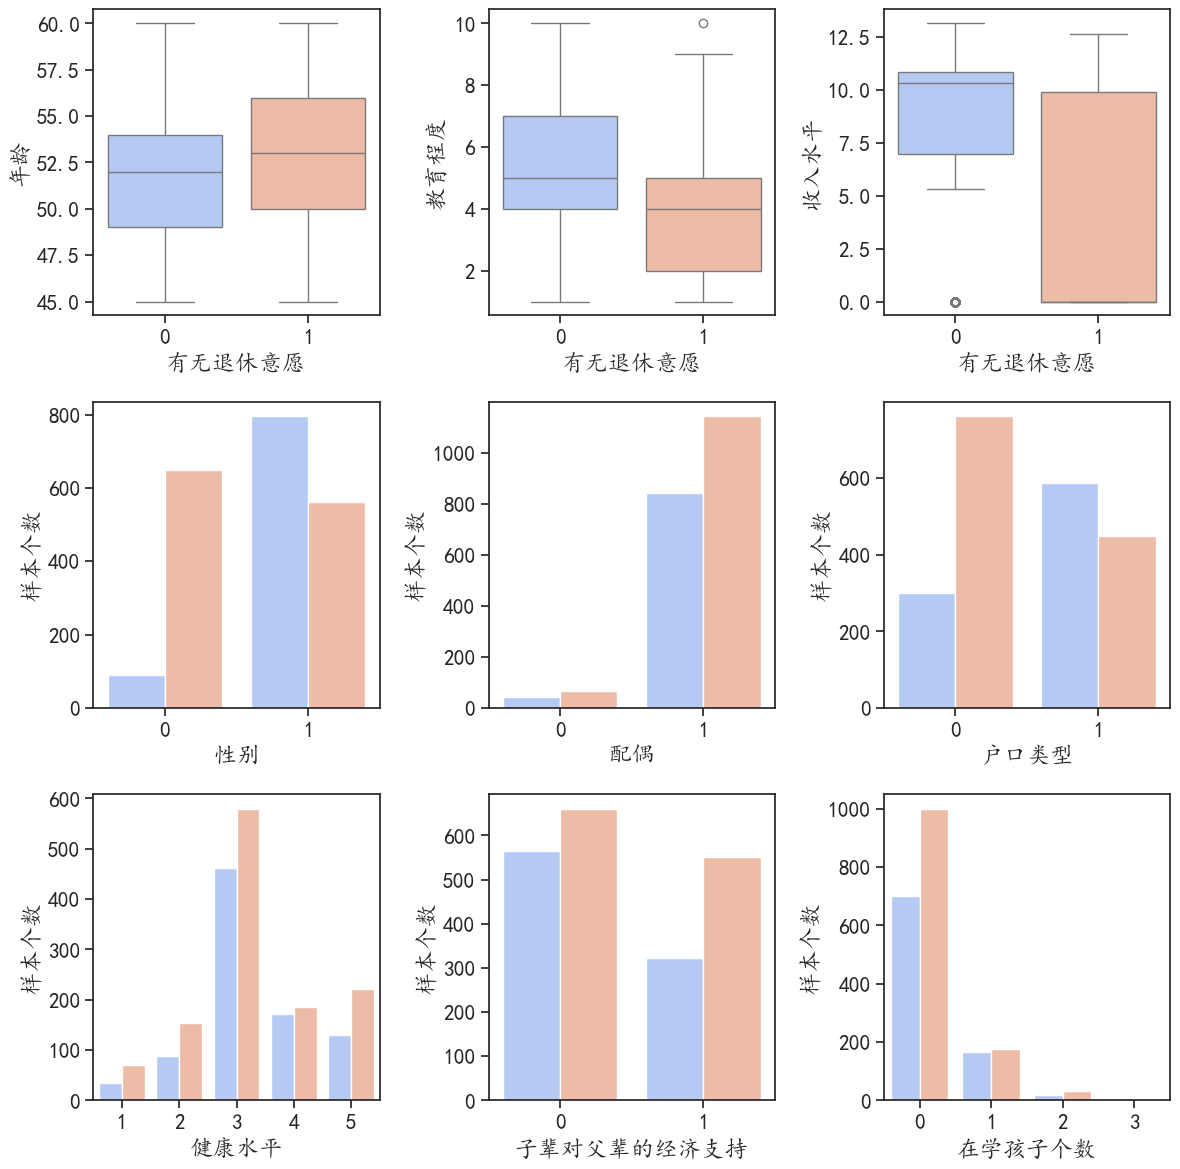

True

In [18]:
analyzer.exploratory_analysis(nums=3)

### **4.构建模型并进行对比**

#### **4.1 逻辑回归模型 -- 变量影响**

In [19]:
analyzer.logistic_regression_analysis()

逻辑回归显著性分析
Optimization terminated successfully.
         Current function value: 0.475095
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                retdelw   No. Observations:                 2096
Model:                          Logit   Df Residuals:                     2086
Method:                           MLE   Df Model:                            9
Date:                Fri, 28 Nov 2025   Pseudo R-squ.:                  0.3025
Time:                        14:25:58   Log-Likelihood:                -995.80
converged:                       True   LL-Null:                       -1427.7
Covariance Type:            nonrobust   LLR p-value:                3.907e-180
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.3976      0.943     -7.848      0.000      -9.245      -5.550
sex           -2.78

True

#### **4.2 多种模型进行对比**

- 划分训练集和测试集

In [20]:
analyzer.prepare_model_data()

训练集形状: (1467, 9)
测试集形状: (629, 9)
训练集目标分布:
retdelw
1    847
0    620
Name: count, dtype: int64
测试集目标分布:
retdelw
1    363
0    266
Name: count, dtype: int64


True

- 逻辑回归训练

In [21]:
analyzer.train_logistic_regression()

训练逻辑回归模型
训练集性能:
逻辑回归训练集准确率: 0.7655
训练集混淆矩阵:
[[454 166]
 [178 669]]
训练集分类报告:
              precision    recall  f1-score   support

           0       0.72      0.73      0.73       620
           1       0.80      0.79      0.80       847

    accuracy                           0.77      1467
   macro avg       0.76      0.76      0.76      1467
weighted avg       0.77      0.77      0.77      1467


------------------------------
测试集性能:
逻辑回归测试集准确率: 0.7440
测试集混淆矩阵:
[[188  78]
 [ 83 280]]
测试集分类报告:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       266
           1       0.78      0.77      0.78       363

    accuracy                           0.74       629
   macro avg       0.74      0.74      0.74       629
weighted avg       0.74      0.74      0.74       629



True

- 决策树模型

In [22]:
analyzer.train_decision_tree()

训练决策树模型
决策树最佳参数: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}
训练集性能:
决策树训练集准确率: 0.8125
训练集混淆矩阵:
[[561  59]
 [216 631]]

------------------------------
测试集性能:
决策树测试集准确率: 0.7297
测试集混淆矩阵:
[[216  50]
 [120 243]]
测试集分类报告:
              precision    recall  f1-score   support

           0       0.64      0.81      0.72       266
           1       0.83      0.67      0.74       363

    accuracy                           0.73       629
   macro avg       0.74      0.74      0.73       629
weighted avg       0.75      0.73      0.73       629



True

- 随机森林模型

训练随机森林模型
随机森林最佳参数: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
训练集性能:
随机森林训练集准确率: 0.8521
训练集混淆矩阵:
[[541  79]
 [138 709]]

------------------------------
测试集性能:
随机森林测试集准确率: 0.7536
测试集混淆矩阵:
[[199  67]
 [ 88 275]]
测试集分类报告:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       266
           1       0.80      0.76      0.78       363

    accuracy                           0.75       629
   macro avg       0.75      0.75      0.75       629
weighted avg       0.76      0.75      0.75       629

特征重要性:
  feature  importance
0     sex    0.306205
4   lwage    0.226668
1     age    0.204991
2     edu    0.096389
5   hukou    0.062714
6    heal    0.053543
8  schkid    0.022688
7    supc    0.022287
3     mar    0.004515


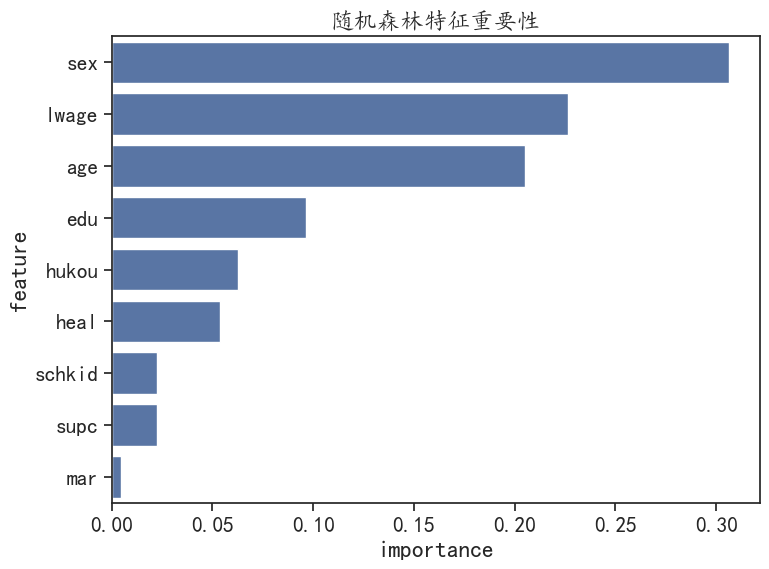

True

In [23]:
analyzer.train_random_forest()